In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

path = "/content/drive/MyDrive/Dataset DSCI 510/combined_nhis_dataset_with_fraud_types (1).csv"
df = pd.read_csv(path)
df.head()

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE
0,1,25.0,F,2025-02-11,2025-02-11,16800.0,CYESIS LMP,Phantom Billing
1,2,30.0,M,2025-02-13,2025-02-13,6300.0,WAX IMPACTION,Wrong Diagnosis
2,3,35.0,M,2025-02-13,2025-02-13,6160.0,CYESIS LMP,Wrong Diagnosis
3,4,48.0,M,2025-02-18,2025-02-18,0.0,TONSILITIS OBSTRUCTIVE SLEEP APEANA,Ghost Enrollee
4,5,58.0,F,2025-02-18,2025-02-18,8400.0,REFRACTIVE ERROR,No Fraud


In [4]:
df['FRAUD_TYPE'].value_counts(dropna=False,normalize=True)

,proportion
FRAUD_TYPE,
No Fraud,0.574063
Phantom Billing,0.207622
Ghost Enrollee,0.201050
Wrong Diagnosis,0.017265


In [5]:
df.shape

(20388, 8)

In [6]:
df.head()

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE
0,1,25.0,F,2025-02-11,2025-02-11,16800.0,CYESIS LMP,Phantom Billing
1,2,30.0,M,2025-02-13,2025-02-13,6300.0,WAX IMPACTION,Wrong Diagnosis
2,3,35.0,M,2025-02-13,2025-02-13,6160.0,CYESIS LMP,Wrong Diagnosis
3,4,48.0,M,2025-02-18,2025-02-18,0.0,TONSILITIS OBSTRUCTIVE SLEEP APEANA,Ghost Enrollee
4,5,58.0,F,2025-02-18,2025-02-18,8400.0,REFRACTIVE ERROR,No Fraud


In [7]:
df.columns = df.columns.astype(str).str.strip().str.lower()

In [8]:
import numpy as np
fraud_type_col = "fraud_type"

s = df[fraud_type_col].astype(str).str.strip().str.lower()

df["fraud_binary"] = np.where(s.isin(["phantom billing", "ghost enrolee", "ghost enrollee"]),
    1,
    0
).astype(int)

In [9]:
df["fraud_binary"].value_counts(dropna=False,normalize=True)

,proportion
fraud_binary,
0,0.591328
1,0.408672


In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
except Exception:
    import sys
    !{sys.executable} -m pip -q install imbalanced-learn
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline

try:
    from IPython.display import display
except Exception:
    display = print

In [11]:
def make_lift_table(y_true: pd.Series, y_prob: np.ndarray, n_bins: int = 10) -> pd.DataFrame:
    y_true = pd.Series(y_true).astype(int).reset_index(drop=True)
    y_prob = pd.Series(np.asarray(y_prob).astype(float)).reset_index(drop=True)

    tmp = pd.DataFrame({"y_true": y_true, "y_prob": y_prob})
    tmp["rank"] = tmp["y_prob"].rank(method="first", ascending=False)
    tmp["decile"] = pd.qcut(tmp["rank"], q=n_bins, labels=range(1, n_bins + 1)).astype(int)

    overall_rate = tmp["y_true"].mean()
    grouped = (
        tmp.groupby("decile", as_index=False)
        .agg(count=("y_true", "size"), responders=("y_true", "sum"), avg_score=("y_prob", "mean"))
        .sort_values("decile")
        .reset_index(drop=True)
    )
    grouped["response_rate"] = grouped["responders"] / grouped["count"]
    grouped["overall_rate"] = overall_rate

    if overall_rate > 0:
        grouped["lift"] = grouped["response_rate"] / overall_rate
    else:
        grouped["lift"] = np.nan

    grouped = grouped[["decile", "count", "responders", "response_rate", "overall_rate", "lift", "avg_score"]]
    return grouped

In [12]:
def top_decile_lift(lift_table: pd.DataFrame) -> float:
    top = lift_table.loc[lift_table["decile"] == 1, "lift"]
    return float(top.iloc[0]) if len(top) else float("nan")

In [ ]:
X2 = df.copy()
y = X2["fraud_binary"].astype(int)
X2 = X2.drop(columns=["fraud_binary", "fraud_type"], errors="ignore")


for col in ["claim_id"]:
    if col in X2.columns:
        X2 = X2.drop(columns=[col])

def cap_top_k(df_in, col, k=30):
    if col not in df_in.columns:
        return df_in
    s = df_in[col].astype("string").str.strip().str.lower().fillna("missing")
    top = s.value_counts().nlargest(k).index
    df_in[col] = s.where(s.isin(top), "other")
    return df_in

for col in ["diagnosis", "treatment"]:
    X2 = cap_top_k(X2, col, k=30)

X_train, X_test, y_train, y_test = train_test_split(
    X2, y, test_size=0.2, random_state=42, stratify=y
)

def add_freq_encoding(train_df, test_df, col):
    if col not in train_df.columns:
        return train_df, test_df
    tr = train_df[col].astype("string").fillna("missing")
    te = test_df[col].astype("string").fillna("missing")
    freq = tr.value_counts()
    train_df[col + "_freq"] = tr.map(freq).astype(float)
    test_df[col + "_freq"] = te.map(freq).fillna(0).astype(float)
    train_df = train_df.drop(columns=[col])
    test_df = test_df.drop(columns=[col])
    return train_df, test_df

for col in ["provider_id", "patient_id"]:
    X_train, X_test = add_freq_encoding(X_train, X_test, col)

X_train_d = pd.get_dummies(X_train, dummy_na=True)
X_test_d  = pd.get_dummies(X_test, dummy_na=True)
X_test_d  = X_test_d.reindex(columns=X_train_d.columns, fill_value=0)

print("X_train_d shape:", X_train_d.shape, "X_test_d shape:", X_test_d.shape)


X_train_d shape: (16310, 5267) X_test_d shape: (4078, 5267)


In [14]:
X_train_lr = X_train_d.fillna(0)
X_test_lr  = X_test_d.fillna(0)

In [15]:
lr = LogisticRegression(max_iter=2000, solver="saga", n_jobs=-1, tol=1e-3)
lr.fit(X_train_lr, y_train)

LogisticRegression(max_iter=2000, n_jobs=-1, solver='saga', tol=0.001)

In [16]:
train_prob = lr.predict_proba(X_train_lr)[:, 1]
test_prob  = lr.predict_proba(X_test_lr)[:, 1]

In [ ]:
import numpy as np
import pandas as pd

def _score_df(y_true, y_prob, n_bins=10):
    y_true = pd.Series(y_true).astype(int).reset_index(drop=True)
    y_prob = pd.Series(np.asarray(y_prob).astype(float)).reset_index(drop=True)

    df_s = pd.DataFrame({"y_true": y_true, "score": y_prob})

    df_s["rank"] = df_s["score"].rank(method="first", ascending=False)
    df_s["decile_bin"] = pd.qcut(df_s["rank"], q=n_bins, labels=False).astype(int)

    return df_s

def _cumulative_table(df_s, prefix="train", n_bins=10):
    overall_rate = df_s["y_true"].mean()
    total_pos = df_s["y_true"].sum()

    rows = []
    n = len(df_s)

    for k in range(1, n_bins + 1):
        sub = df_s[df_s["decile_bin"] < k]
        cnt = len(sub)
        pos = int(sub["y_true"].sum())

        rate = (pos / cnt) if cnt > 0 else np.nan
        recall = (pos / total_pos) if total_pos > 0 else np.nan
        lift = (rate / overall_rate) if overall_rate > 0 else np.nan

        rows.append({
            "decile": k * 10,  
            f"{prefix}_target": pos,
            f"{prefix}_claims": cnt,
            f"{prefix}_recall": recall,
            f"{prefix}_rate": rate,
            f"{prefix}_overall_rate": overall_rate,
            f"{prefix}_lift": lift
        })

    return pd.DataFrame(rows)

def get_lift_table(y_train, train_prob, y_test, test_prob, n_bins=10):
    train_scored = _score_df(y_train, train_prob, n_bins=n_bins)
    test_scored  = _score_df(y_test,  test_prob,  n_bins=n_bins)

    train_tbl = _cumulative_table(train_scored, prefix="train", n_bins=n_bins)
    test_tbl  = _cumulative_table(test_scored,  prefix="test",  n_bins=n_bins)

    out = train_tbl.merge(test_tbl, on="decile", how="inner")

    out = out[[
        "decile",
        "train_target", "train_claims", "train_recall", "train_rate", "train_overall_rate", "train_lift",
        "test_target",  "test_claims",  "test_recall",  "test_rate",  "test_overall_rate",  "test_lift"
    ]]

    return out, train_scored, test_scored

lift_table, train_scored_df, test_scored_df = get_lift_table(y_train, train_prob, y_test, test_prob, n_bins=10)

display(lift_table)              
display(train_scored_df.head())  
display(test_scored_df.head())   

,decile,train_target,train_claims,train_recall,train_rate,train_overall_rate,train_lift,test_target,test_claims,test_recall,test_rate,test_overall_rate,test_lift
0,10,802,1631,0.120330,0.491723,0.408645,1.203301,202,408,0.121176,0.495098,0.408779,1.211164
1,20,2019,3262,0.302926,0.618945,0.408645,1.514629,523,816,0.313737,0.640931,0.408779,1.567917
2,30,3161,4893,0.474269,0.646025,0.408645,1.580895,804,1224,0.482304,0.656863,0.408779,1.606890
3,40,4210,6524,0.631658,0.645310,0.408645,1.579145,1079,1631,0.647271,0.661557,0.408779,1.618375
4,50,4925,8155,0.738935,0.603924,0.408645,1.477869,1238,2039,0.742651,0.607160,0.408779,1.485303
5,60,5349,9786,0.802551,0.546597,0.408645,1.337584,1348,2447,0.808638,0.550879,0.408779,1.347620
6,70,5781,11417,0.867367,0.506350,0.408645,1.239095,1446,2854,0.867427,0.506657,0.408779,1.239441
7,80,6212,13048,0.932033,0.476088,0.408645,1.165041,1557,3262,0.934013,0.477315,0.408779,1.167660
8,90,6546,14679,0.982146,0.445943,0.408645,1.091273,1641,3670,0.984403,0.447139,0.408779,1.093841
9,100,6665,16310,1.000000,0.408645,0.408645,1.000000,1667,4078,1.000000,0.408779,0.408779,1.000000


,y_true,score,rank,decile_bin
0,1,0.439251,6415.0,3
1,1,0.189121,13830.0,8
2,0,0.181693,14086.0,8
3,1,0.442360,6257.0,3
4,0,0.167794,14490.0,8


,y_true,score,rank,decile_bin
0,0,0.679739,43.0,0
1,1,0.676653,46.0,0
2,0,0.365178,2111.0,5
3,0,0.162726,3672.0,9
4,0,0.125772,3898.0,9


In [34]:
print("coef shape:", lr.coef_.shape)
print("intercept shape:", lr.intercept_.shape)
print("n_iter:", lr.n_iter_)
print("train prob sample:", train_prob[:5])


coef shape: (1, 5267)
intercept shape: (1,)
n_iter: [642]
train prob sample: [0.43925141 0.18912083 0.18169327 0.44235984 0.16779439]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

target_low, target_high = 0.80, 0.90
thresholds = np.linspace(0.01, 0.99, 199)

rows = []
for t in thresholds:
    pred = (test_prob >= t).astype(int)
    rows.append({
        "threshold": float(t),
        "precision": precision_score(y_test, pred, zero_division=0),
        "recall": recall_score(y_test, pred, zero_division=0),
        "f1": f1_score(y_test, pred, zero_division=0),
        "flag_rate": pred.mean()
    })

thr_df = pd.DataFrame(rows)

band = thr_df[(thr_df["recall"] >= target_low) & (thr_df["recall"] <= target_high)].copy()

if band.empty:
    thr_df["gap"] = (thr_df["recall"] - 0.85).abs()
    band = thr_df.sort_values(["gap", "precision", "f1"], ascending=[True, False, False])

best = band.sort_values(["precision", "f1"], ascending=[False, False]).iloc[0]
t_star = float(best["threshold"])

print("Chosen threshold:", round(t_star, 4))
print("Test precision:", round(float(best["precision"]), 4))
print("Test recall:", round(float(best["recall"]), 4))
print("Test F1:", round(float(best["f1"]), 4))
print("Flag rate:", round(float(best["flag_rate"]), 4))

train_pred = (train_prob >= t_star).astype(int)
test_pred  = (test_prob  >= t_star).astype(int)

print("\nTRAIN confusion matrix:\n", confusion_matrix(y_train, train_pred))
print("TRAIN precision:", round(precision_score(y_train, train_pred, zero_division=0), 4))
print("TRAIN recall:", round(recall_score(y_train, train_pred, zero_division=0), 4))
print("TRAIN F1:", round(f1_score(y_train, train_pred, zero_division=0), 4))

print("\nTEST confusion matrix:\n", confusion_matrix(y_test, test_pred))
print("TEST precision:", round(precision_score(y_test, test_pred, zero_division=0), 4))
print("TEST recall:", round(recall_score(y_test, test_pred, zero_division=0), 4))
print("TEST F1:", round(f1_score(y_test, test_pred, zero_division=0), 4))

display(band.head(15))


Chosen threshold: 0.3169
Test precision: 0.554
Test recall: 0.8068
Test F1: 0.6569
Flag rate: 0.5954

TRAIN confusion matrix:
 [[5155 4490]
 [1293 5372]]
TRAIN precision: 0.5447
TRAIN recall: 0.806
TRAIN F1: 0.6501

TEST confusion matrix:
 [[1328 1083]
 [ 322 1345]]
TEST precision: 0.554
TEST recall: 0.8068
TEST F1: 0.6569


,threshold,precision,recall,f1,flag_rate
46,0.237677,0.491269,0.894421,0.634198,0.744237
47,0.242626,0.493338,0.888422,0.634397,0.736145
48,0.247576,0.496959,0.882424,0.635833,0.725846
49,0.252525,0.500171,0.875225,0.636562,0.715302
50,0.257475,0.503812,0.872226,0.638700,0.707700
51,0.262424,0.507190,0.867427,0.640106,0.699117
52,0.267374,0.510691,0.859628,0.640733,0.688082
53,0.272323,0.512987,0.853029,0.640685,0.679745
54,0.277273,0.519090,0.848230,0.644045,0.667974
55,0.282222,0.522355,0.841032,0.644450,0.658166


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0.01, 0.99, 99)
rows = []
for t in thresholds:
    pred = (test_prob >= t).astype(int)
    rows.append({
        "threshold": float(t),
        "precision": precision_score(y_test, pred, zero_division=0),
        "recall": recall_score(y_test, pred, zero_division=0),
        "flag_rate": pred.mean()
    })

thr_df = pd.DataFrame(rows)

min_precision = 0.20  
cand = thr_df[thr_df["precision"] >= min_precision].sort_values(
    ["recall", "precision"], ascending=[False, False]
)

t_star = float(cand.iloc[0]["threshold"]) if len(cand) else float(thr_df.sort_values("recall", ascending=False).iloc[0]["threshold"])
t_star


0.11

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

test_pred  = (test_prob  >= t_star).astype(int)
train_pred = (train_prob >= t_star).astype(int)

print("TRAIN")
print("Precision:", round(precision_score(y_train, train_pred, zero_division=0), 4))
print("Recall:   ", round(recall_score(y_train, train_pred, zero_division=0), 4))
print("F1:       ", round(f1_score(y_train, train_pred, zero_division=0), 4))
print("Confusion matrix:\n", confusion_matrix(y_train, train_pred))


TRAIN
Precision: 0.4168
Recall:    1.0
F1:        0.5884
Confusion matrix:
 [[ 319 9326]
 [   0 6665]]


In [ ]:
print("\nTEST")
print("Precision:", round(precision_score(y_test, test_pred, zero_division=0), 4))
print("Recall:   ", round(recall_score(y_test, test_pred, zero_division=0), 4))
print("F1:       ", round(f1_score(y_test, test_pred, zero_division=0), 4))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))



TEST
Precision: 0.4182
Recall:    1.0
F1:        0.5898
Confusion matrix:
 [[  92 2319]
 [   0 1667]]


In [ ]:
print("\nClassification report (TEST):\n")
print(classification_report(y_test, test_pred, digits=4, zero_division=0))


Classification report (TEST):

              precision    recall  f1-score   support

           0     0.6591    0.8635    0.7476      2411
           1     0.6420    0.3539    0.4563      1667

    accuracy                         0.6552      4078
   macro avg     0.6505    0.6087    0.6019      4078
weighted avg     0.6521    0.6552    0.6285      4078



<Figure size 640x480 with 0 Axes>

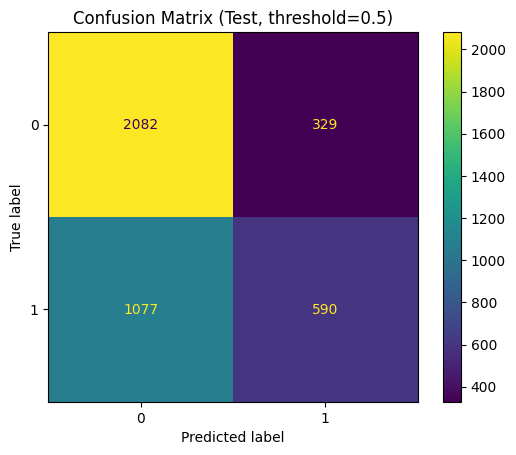

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay

train_pred = (train_prob >= 0.5).astype(int)
test_pred  = (test_prob  >= 0.5).astype(int)

plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, test_pred)
plt.title("Confusion Matrix (Test, threshold=0.5)")
plt.show()


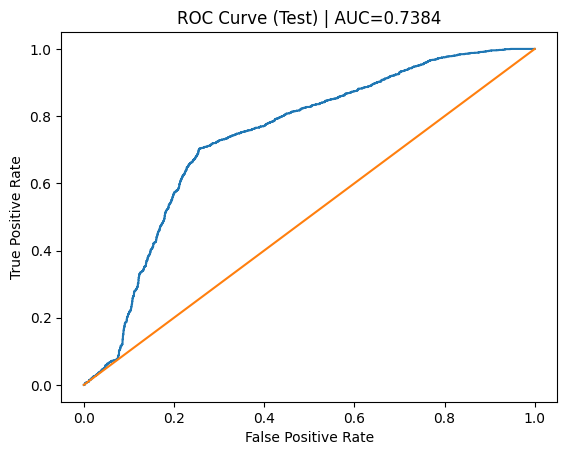

In [ ]:
fpr, tpr, _ = roc_curve(y_test, test_prob)
auc = roc_auc_score(y_test, test_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Test) | AUC={auc:.4f}")
plt.show()

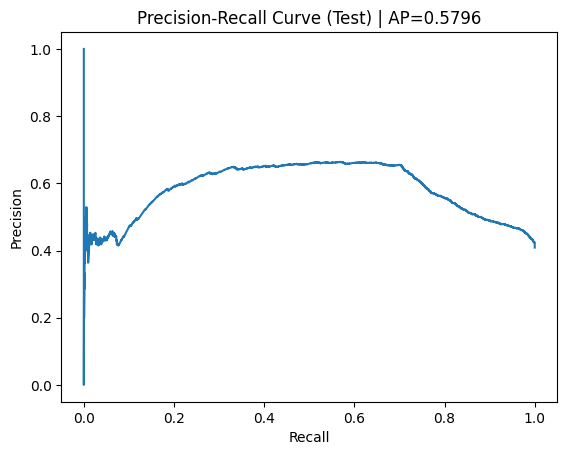

In [ ]:
prec, rec, _ = precision_recall_curve(y_test, test_prob)
ap = average_precision_score(y_test, test_prob)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (Test) | AP={ap:.4f}")
plt.show()

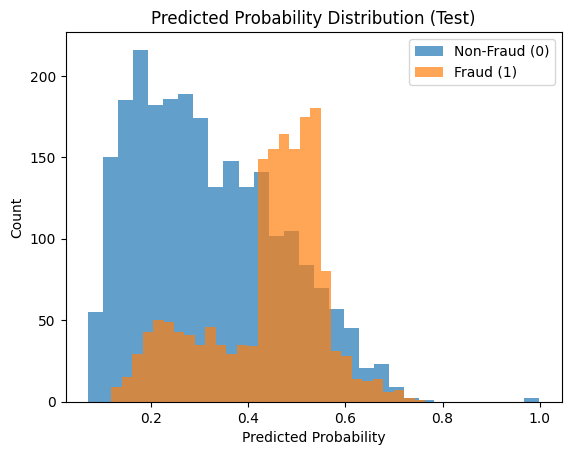

In [ ]:
pos_scores = test_prob[np.asarray(y_test) == 1]
neg_scores = test_prob[np.asarray(y_test) == 0]

plt.figure()
plt.hist(neg_scores, bins=30, alpha=0.7, label="Non-Fraud (0)")
plt.hist(pos_scores, bins=30, alpha=0.7, label="Fraud (1)")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Predicted Probability Distribution (Test)")
plt.legend()
plt.show()
